In [91]:
import sqlite3
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pickle


import os

In [92]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [93]:
from scipy.stats import iqr


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
db = r'C:/Users/jonat/UO_Bootcamp/Group_project/git_Water_Quality_Analysis/Water_Quality_Analysis/Database/database.sqlite3'
# Connect to SQLite database
conn = sqlite3.connect(db)
  
# Create cursor object
cursor = conn.cursor()

#Read in the Data from the DB
df = pd.read_sql_query("SELECT * FROM Census_Data INNER JOIN Contaminant_Summary on Census_Data.county_FIPS = Contaminant_Summary.county_FIPS",conn)

In [96]:
#Get the target binary data from the .csv file that was generated in the Priority_algo_dev.ipynb
target = pd.read_csv(os.path.join('..', '..', 'Priority_Algo_dev', 'new_priority.csv'), usecols=['New_Priority'])
target

,New_Priority
0,0
1,1
2,1
3,1
4,0
...,...
877,0
878,0
879,0
880,1


In [97]:
sr = pd.Series(target.New_Priority)
sr

0      0
1      1
2      1
3      1
4      0
      ..
877    0
878    0
879    0
880    1
881    1
Name: New_Priority, Length: 882, dtype: int64

In [98]:
target_labels = sr.apply(lambda x : 'High Priority' if x>0 else 'Low Priority')

In [99]:
df['Target'] = target.New_Priority

## Feature Selection

In [100]:
df_model = df.drop(columns=['county_FIPS', 
                            'Geographic_Area_Name', 
                            'County', 'GEOID',
                            'Total_Population',
                            'White', 
                            'Black', 
                            'Native', 
                            'Asian',
                            'Pacific_Islander', 
                            'Other', 
                            'Two_or_more_Races', 
                            'Hispanic',
                            'Not_Hispanic', 
                            'Not_White',
                            'pct_White', 
                            'pct_Black', 
                            'pct_Native',
                            'pct_Asian', 
                            'pct_Pacific_Islander', 
                            'pct_Other', 
                            'pct_Not_White',
                            'pct_Hispanic', 
                            'pct_Not_Hispanic', 
                            'pct_Two_or_more_Races',
                            'County_FIPS',
                            'Sum_Population_Served',
                            'Min_Contaminant_Factor', 
                            'Max_Contaminant_Factor',
                            ])

In [101]:
#Check to make sure the data types don't need fixing
df_model.dtypes

Simpson_Race_DI           float64
Simpson_Ethnic_DI         float64
Shannon_Race_DI           float64
Shannon_Ethnic_DI         float64
Gini_Index                float64
Num_Contaminants            int64
Sum_ContaminantFactor       int64
Avg_Contaminant_Factor    float64
Target                      int64
dtype: object

In [102]:
#Check for Nan even though cleaning scripts should have excluded them by this stage
df_model.isna().sum()

Simpson_Race_DI           0
Simpson_Ethnic_DI         0
Shannon_Race_DI           0
Shannon_Ethnic_DI         0
Gini_Index                0
Num_Contaminants          0
Sum_ContaminantFactor     0
Avg_Contaminant_Factor    0
Target                    0
dtype: int64

## Filter the Data using the IQR method

In [103]:
percentile25 = df_model['Sum_ContaminantFactor'].quantile(0.25)
percentile75 = df_model['Sum_ContaminantFactor'].quantile(0.75)

In [104]:
SCF_IQR = iqr(df_model['Sum_ContaminantFactor'])

In [105]:
print(percentile25, percentile75, SCF_IQR)

1966.5 11049.5 9083.0


In [106]:
upper_limit = percentile75 + 1.5 * SCF_IQR
lower_limit = percentile25 - 1.5 * SCF_IQR

In [107]:
new_df = df_model[df_model['Sum_ContaminantFactor'] < upper_limit]


In [108]:
new_df['Label'] = target_labels

In [109]:
new_df.sample(20)

,Simpson_Race_DI,Simpson_Ethnic_DI,Shannon_Race_DI,Shannon_Ethnic_DI,Gini_Index,Num_Contaminants,Sum_ContaminantFactor,Avg_Contaminant_Factor,Target,Label
811,0.123800,0.024524,0.362783,0.066826,0.4616,3,3856,1285.33,0,Low Priority
461,0.595608,0.265007,1.523013,0.435026,0.3817,3,8607,2869.00,1,High Priority
600,0.149196,0.041241,0.443405,0.102151,0.4200,4,106,26.50,0,Low Priority
271,0.126232,0.050211,0.418627,0.119712,0.4202,5,3964,792.80,0,Low Priority
563,0.094933,0.023446,0.302269,0.064395,0.4524,1,926,926.00,0,Low Priority
148,0.403550,0.325308,1.179164,0.506509,0.4353,9,2897,321.89,0,Low Priority
63,0.487995,0.100374,1.076582,0.207240,0.4363,15,5281,352.07,0,Low Priority
408,0.209698,0.037032,0.565055,0.093614,0.4291,11,13612,1237.45,0,Low Priority
401,0.218188,0.056749,0.612333,0.132048,0.4381,10,7270,727.00,0,Low Priority
48,0.399721,0.089576,0.956214,0.189574,0.4594,1,1096,1096.00,0,Low Priority


In [110]:
new_df.shape

(834, 10)

In [111]:
df_model.shape

(882, 9)

In [112]:
new_df.columns

Index(['Simpson_Race_DI', 'Simpson_Ethnic_DI', 'Shannon_Race_DI',
       'Shannon_Ethnic_DI', 'Gini_Index', 'Num_Contaminants',
       'Sum_ContaminantFactor', 'Avg_Contaminant_Factor', 'Target', 'Label'],
      dtype='object')

In [113]:
fig = px.scatter(
    new_df, 
    x="Simpson_Ethnic_DI", 
    y="Sum_ContaminantFactor", 
    color="Label",
    size='Num_Contaminants', 
    hover_data=['Sum_ContaminantFactor'],
    labels={
        "Sum_ContaminantFactor": "Total Conatmainant Factor",
        "Simpson_Ethnic_DI" : " Simpson Ethnic Index"
                     
                 },
)

fig.update_layout(
    title={
        'text': "Plot of the Adaboost Top Feature Importance",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()


In [114]:
fig = px.scatter(
    new_df, 
    x="Shannon_Ethnic_DI", 
    y="Sum_ContaminantFactor", 
    color="Label",
    size='Num_Contaminants', 
    hover_data=['Sum_ContaminantFactor'],
    labels={
        "Sum_ContaminantFactor": "Total Conatmainant Factor",
        "Shannon_Ethnic_DI" : " Shannon Ethnic Index"
                     
                 },
)

fig.update_layout(
    title={
        'text': "Plot of the Adaboost Top Feature Importance",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()

<Figure size 2160x2160 with 0 Axes>

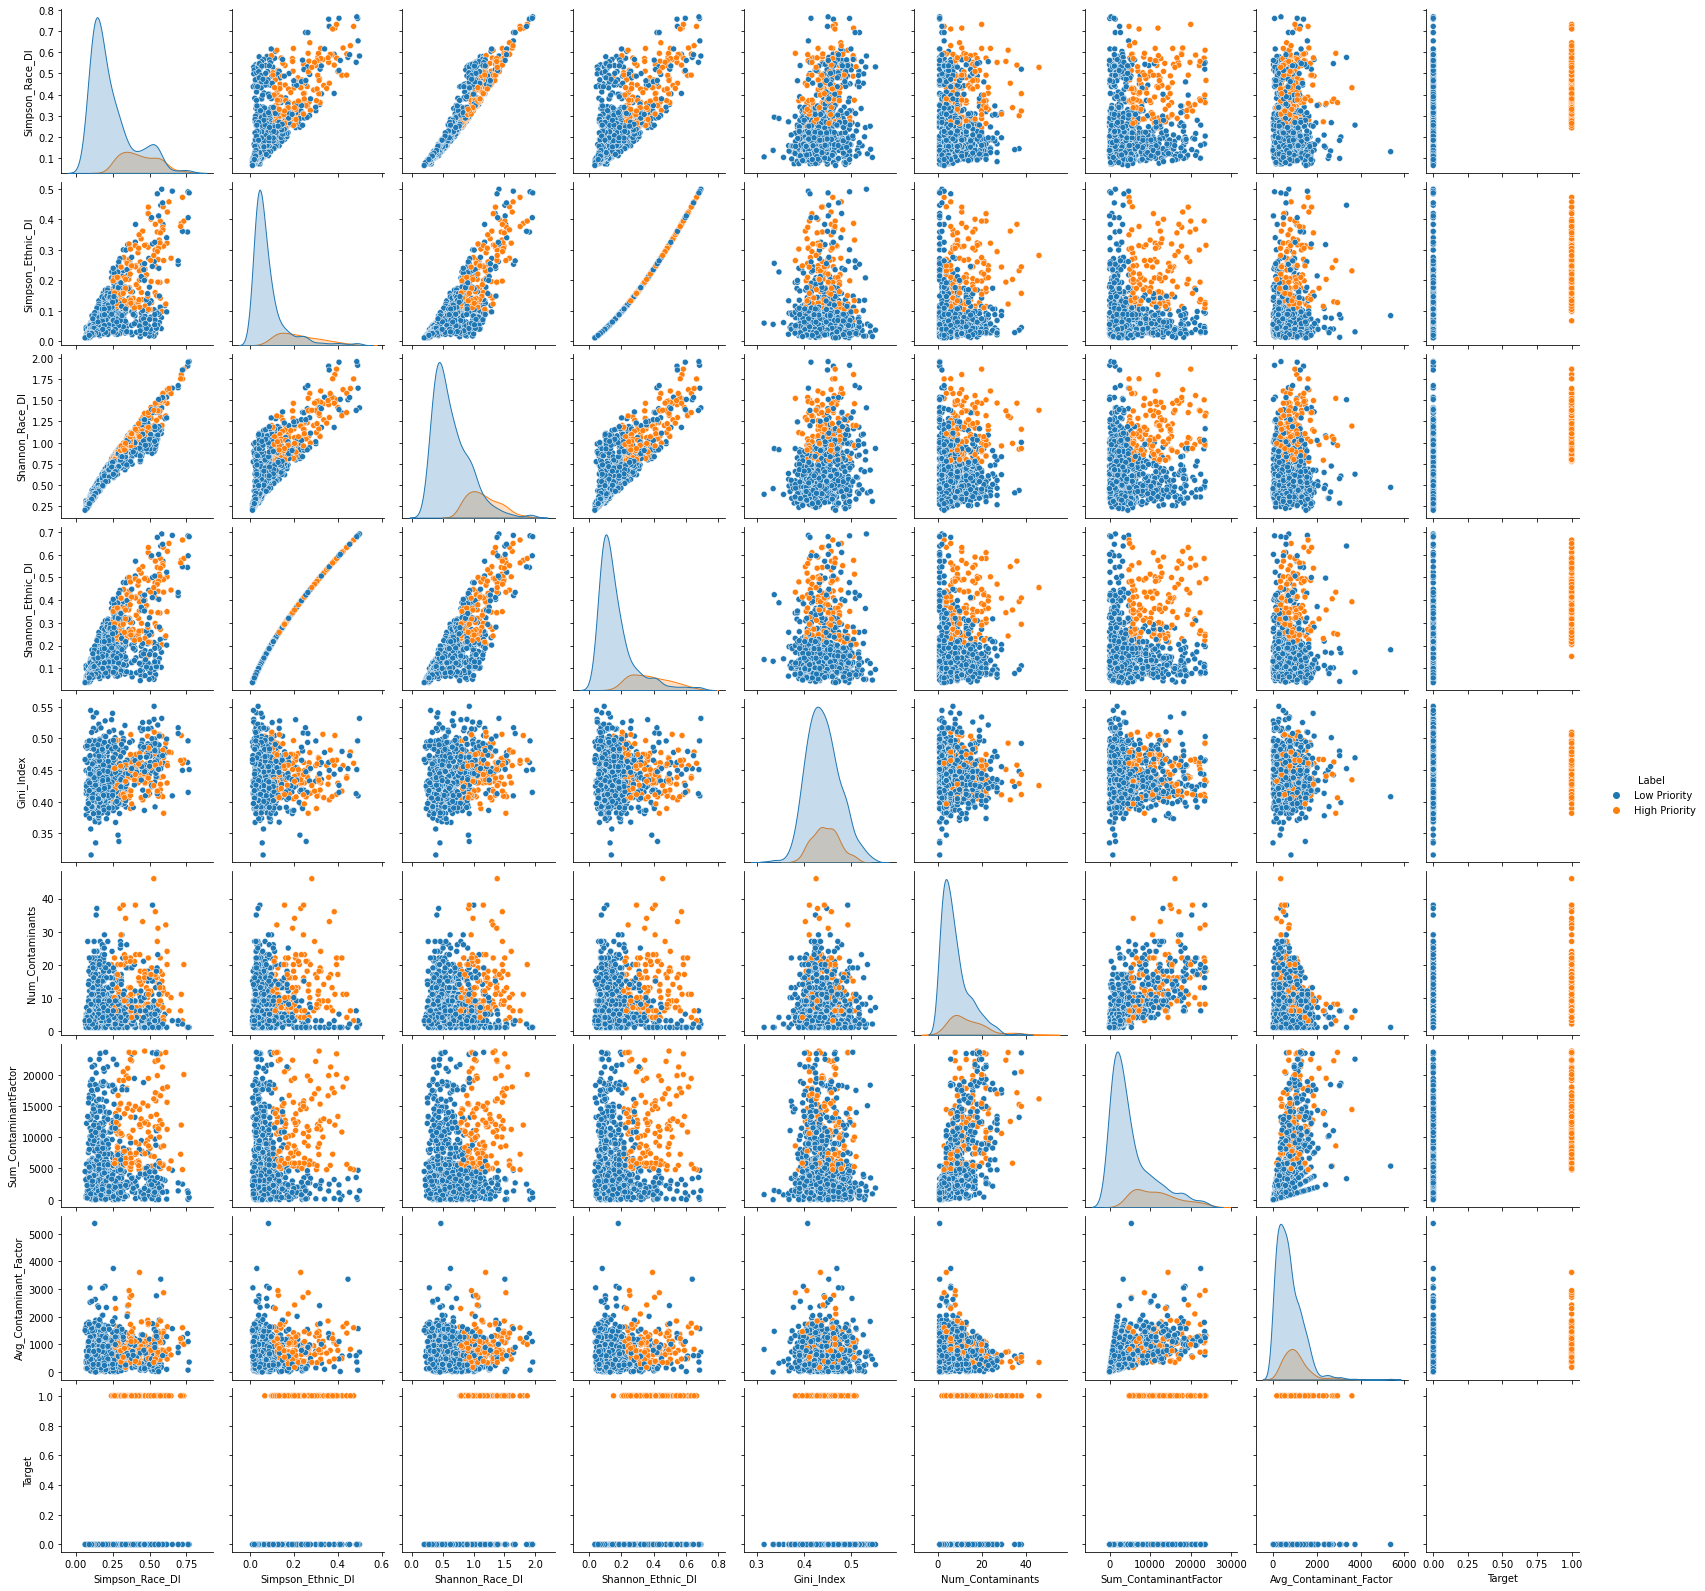

In [115]:
plt.figure(figsize=(30,30))
sns.pairplot(new_df, hue='Label')

## Drop extra features then split the data into training and test data

In [116]:
new_df.columns

Index(['Simpson_Race_DI', 'Simpson_Ethnic_DI', 'Shannon_Race_DI',
       'Shannon_Ethnic_DI', 'Gini_Index', 'Num_Contaminants',
       'Sum_ContaminantFactor', 'Avg_Contaminant_Factor', 'Target', 'Label'],
      dtype='object')

In [117]:
mdf = new_df.drop(columns=['Shannon_Ethnic_DI', 'Simpson_Race_DI', 'Target', 'Label'])
mdf.sample(5)

,Simpson_Ethnic_DI,Shannon_Race_DI,Gini_Index,Num_Contaminants,Sum_ContaminantFactor,Avg_Contaminant_Factor
767,0.018794,0.271860,0.4112,9,7936,881.78
98,0.069004,0.554265,0.4852,1,126,126.00
426,0.092984,1.164492,0.4658,19,23578,1240.95
818,0.016446,0.274129,0.3967,5,4497,899.40
647,0.037614,0.400051,0.4195,3,1106,368.67


In [118]:
# Create our features
X = mdf
# Create our target
y = new_df.Target

In [119]:
# define standard scaler
scaler = StandardScaler()
# transform data
X_scaled = scaler.fit_transform(X)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [121]:
#Check the imbalance in the training set
y_train.value_counts()

0    521
1    104
Name: Target, dtype: int64

### Easy Ensemble AdaBoost Classifier

In [122]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train,y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [123]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9767226890756302

In [124]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm, index=["Actual High-Priority", "Actual Low-Priority"],
    columns=["Predicted High-Priority", "Predicted Low-Priority"]
)

# Displaying results
display(cm_df)

,Predicted High-Priority,Predicted Low-Priority
Actual High-Priority,172,3
Actual Low-Priority,1,33


In [125]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.97      0.99      0.98      0.96       175
          1       0.92      0.97      0.98      0.94      0.98      0.95        34

avg / total       0.98      0.98      0.97      0.98      0.98      0.95       209



In [126]:
y_score = eec.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [127]:
# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=y_score, color=y, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

In [128]:
precision, recall, thresholds = precision_recall_curve(y, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

## Save the model using pickle

In [129]:
# save the model to disk
filename = 'EEC_model.sav'
pickle.dump(eec, open(filename, 'wb'))
 

## some time later...
 

In [130]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9808612440191388


# Balanced Random Forest Classifier

In [131]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 
brf_model.fit(X_train,y_train)
# Calculated the balanced accuracy score
y_pred = brf_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.982436974789916

In [132]:
# List the features sorted in descending order by feature importance
sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

[(0.3328339120046307, 'Simpson_Ethnic_DI'),
 (0.30260330303838934, 'Shannon_Race_DI'),
 (0.2502549828888729, 'Sum_ContaminantFactor'),
 (0.060136657356903975, 'Num_Contaminants'),
 (0.03967709824887343, 'Avg_Contaminant_Factor'),
 (0.014494046462329805, 'Gini_Index')]